In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
#import bamboolib as bam

import unicodedata
import re
import json

import acquire

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 

#statistical tests
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup
import prepare
import plotly.express as px

#imports to show interactive visuals on github
import plotly.io as pio
pio.renderers

#forces dataframe to show every columns
pd.set_option('display.max_columns', None)
import model

***

# `Acquire` Data.

In [2]:
df = acquire.get_fifa_data()
df.shape

/var/folders/dc/8rtfvpyj2mb6mqbnfkf5dl400000gn/T/ipykernel_27491/674559181.py:1: DtypeWarning:

Columns (81,85,104) have mixed types.Specify dtype option on import or set low_memory=False.



(142079, 111)

***

# Import [Prepare.py](https://github.com/Jules-Ray-Kayla-Bert-Capstone-FiFA/fifa/blob/main/prepare.py) File.
`Summary:`
    This file was created with the purpose of cleaning, encoding, scaling, dropping, and adding collumns to our existing data. It is necessary to complete this preperation step before we start exploring and modeling our data.

In [3]:
#defining df as our imported prepped data.
df = prepare.prepped_data(df)
df

Before dropping nulls, 142079 rows, 111 cols
After dropping nulls. 131489 rows. 66 cols
After cleaning the data and adding additional columns there are: 98804 rows. 83 cols


,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,club_name,league_name,nationality_id,nationality_name,club_position,position,field_position,club_joined,club_contract_valid_until,body_type,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,pace,shooting,passing,dribbling,defending,physical,crossing,finishing,heading_accuracy,short_passing,volleys,skill_dribbling,curve,fk_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,gk_speed,year,total_wage,age_bins,height_bins,weight_bins,year_joined,wage_year,league_yr_sum,club_name_yr_sum,seniority,club_position_encoded,work_rate_encoded,preferred_foot_encoded,age_bins_encoded,weight_bins_encoded,body_type_encoded,league_encoded
0,158023,L. Messi,"RW, ST, CF",93,93,78000000.0,320000.0,34,170,72,73.0,Paris Saint-Germain,French Ligue 1,52,Argentina,RW,Right Wing,Forward,2021-08-10,2023.0,Unique,Left,4,4,5,Medium/Low,85,92,91,95,34,65,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,20,35,24,6,11,15,14,8,0,2022,78320000.0,older,short,average,2021,16640000.0,5.034099e+09,991694600.0,1,1,4,1,1,2,1,4
1,190871,Neymar Jr,"LW, CAM",91,91,129000000.0,270000.0,29,175,68,73.0,Paris Saint-Germain,French Ligue 1,54,Brazil,LW,Left Wing,Forward,2017-08-03,2025.0,Unique,Right,5,5,5,High/Medium,91,83,86,94,37,63,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,35,32,29,9,9,15,15,11,0,2022,129270000.0,younger,medium,slim,2017,14040000.0,5.034099e+09,991694600.0,5,3,8,2,2,1,1,4
2,231747,K. Mbappé,"ST, LW",91,95,194000000.0,230000.0,22,182,73,73.0,Paris Saint-Germain,French Ligue 1,18,France,ST,Striker,Forward,2018-07-01,2022.0,Unique,Right,4,5,4,High/Low,97,88,80,92,36,77,78,93,72,85,83,93,80,69,71,91,97,97,92,93,83,86,78,88,77,82,62,38,92,82,79,26,34,32,13,5,7,11,6,0,2022,194230000.0,younger,medium,average,2018,11960000.0,5.034099e+09,991694600.0,4,2,7,2,2,2,1,4
3,230621,G. Donnarumma,GK,89,93,119500000.0,110000.0,22,196,90,73.0,Paris Saint-Germain,French Ligue 1,27,Italy,GK,Goalkeeper,Goalkeeper,2021-07-15,2026.0,Unique,Right,3,1,3,Medium/Medium,0,0,0,0,0,0,12,12,12,36,8,28,12,14,34,30,50,55,64,85,38,59,72,34,72,18,30,26,14,60,24,20,14,16,91,83,79,85,90,52,2022,119610000.0,younger,tall,heavy,2021,5720000.0,5.034099e+09,991694600.0,1,5,5,2,2,3,1,4
4,155862,Sergio Ramos,CB,88,88,24000000.0,115000.0,35,184,82,73.0,Paris Saint-Germain,French Ligue 1,45,Spain,LCB,Left Centre Back,Defender,2021-07-08,2023.0,Unique,Right,3,3,4,High/Medium,70,70,76,74,88,84,66,65,92,82,69,65,74,76,83,83,71,69,77,92,66,79,93,78,84,64,90,87,73,71,92,84,89,91,11,8,9,7,11,0,2022,24115000.0,older,medium,average,2021,5980000.0,5.034099e+09,991694600.0,1,8,8,2,1,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98799,234292,L. Järvenpää,RB,57,70,180000.0,500.0,19,182,76,100325.0,HJK Helsinki,Finnish Veikkausliiga,17,Finland,SUB,Substitute,Subs,2016-01-01,2020.0,Normal (170-185),Right,3,2,1,Medium/Medium,70,26,41,43,55,66,56,25,52,41,23,41,37,31,30,35,67,72,59,50,63,27,60,79,63,23,57,56,42,38,35,57,53,52,14,15,6,8,9,0,2017,180500.0,younger,medium,average,2016,26000.0,3.504800e+06,3504800.0,1,12,5,2,2,2,2,42
98800,234294,L. Lingman,RW,57,72,230000.0,500.0,18,174,65,100325.0,HJK Helsinki,Finnish Veikkausliiga,17,Finland,SUB,Substitute,Subs,2016-01-01,2020.0,Lean (170-185),Right,3,2,1,Medium/Medium,70,46,50,63,29,56,61,45,39,51,45,61,34,41,45,59,68,72,81,56,82,52,67,82,52,41,31,25,52,49

In [4]:
df.wage_eur.describe()

count     98804.000000
mean      13080.606554
std       25428.912656
min         500.000000
25%        2000.000000
50%        4000.000000
75%       13000.000000
max      575000.000000
Name: wage_eur, dtype: float64

In [5]:
cols = ['wage_eur'] 
def handle_outliers(df, cols, k):
    """this will eliminate most outliers, use a 1.5 k value if unsure because it is the most common, make sure to define cols value as the features
    you want the outliers to be handled. this should be done before running the function and outiside of it"""

    
    # Create placeholder dictionary for each columns bounds
    bounds_dict = {}
   
    for col in cols:
        # get necessary iqr values
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound =  q3 + k * iqr
        lower_bound =  q1 - k * iqr

        #store values in a dictionary referencable by the column name
        #and specific bound
        bounds_dict[col] = {}
        bounds_dict[col]['upper_bound'] = upper_bound
        bounds_dict[col]['lower_bound'] = lower_bound

    for col in cols:
        #retrieve bounds
        col_upper_bound = bounds_dict[col]['upper_bound']
        col_lower_bound = bounds_dict[col]['lower_bound']

        #remove rows with an outlier in that column
        df = df[(df[col] < col_upper_bound) & (df[col] > col_lower_bound)]
        
    return df

df = handle_outliers(df,cols,1.5)
# def discard_outliers(df, k, cols):
#     for col in cols:
#         #obtain quartiles
#         q1, q3 = df[col].quantile([.25, .75])
#         #obtain iqr range
#         iqr = q3 - q1
#         upper_bound = q3 + k * iqr
#         lower_bound = q1 - k * iqr
#         #return outlier - free df
#         df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
#     return df
# df = discard_outliers(df, 1.5, cols)

In [6]:
# with oulier model 85921 %87 data retention # manual removal 83813 %85 data retention
#df = df[((df['wage_eur']) <= 22000)]
#df

In [7]:
train, validate, test = prepare.split(df)

Train: 49313 rows, 83 cols
Validate: 23760 rows, 83 cols
Test: 12848 rows, 83 cols


In [8]:
train.wage_eur.describe()

count    49313.000000
mean      6146.776712
std       5729.021648
min        500.000000
25%       2000.000000
50%       4000.000000
75%       8000.000000
max      25000.000000
Name: wage_eur, dtype: float64

# `Explore`

## Importing split function to start our exploring on our train data.

***
# Relationship to Wage_euro Plot

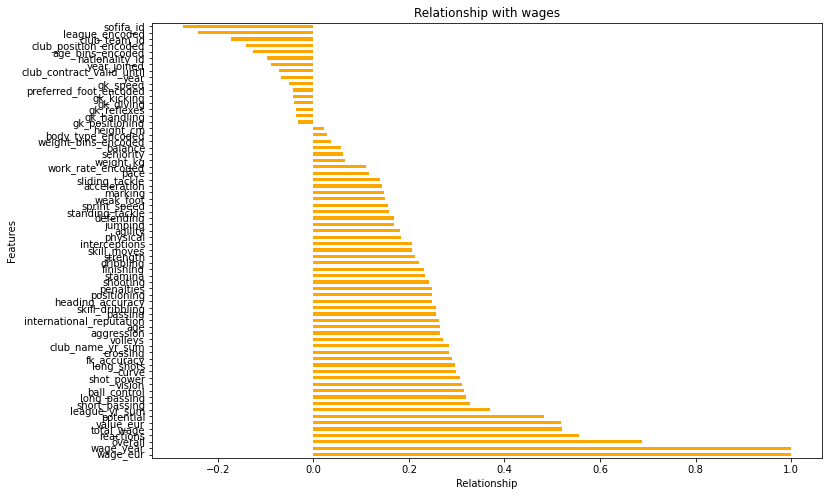

In [9]:
plt.figure(figsize = (12,8))
train.corr()['wage_eur'].sort_values(ascending=False).plot(kind='barh', color='orange')
plt.title('Relationship with wages')
plt.xlabel('Relationship')
plt.ylabel('Features')
plt.show()

In [10]:
features_cor =  train.corr()['wage_eur'].sort_values(ascending=False)
features_cor = pd.DataFrame(features_cor)
features_cor.tail(60)

,wage_eur
short_passing,0.327740
long_passing,0.319484
ball_control,0.315632
vision,0.311231
shot_power,0.306403
curve,0.298399
long_shots,0.297434
fk_accuracy,0.289734
crossing,0.284780
club_name_yr_sum,0.283115


`Takeaways:` 
For this Exploration section I wil be focusing on the skills that are under or equal to 70 percent of correlation and greater then 48 percent. 
The list below will be the skills and stats that I will be focusing on.

- overall
- passing
- ball_control
- short_passing
- reactions
- potential
- dribbling
- vision
- skill_dribbling
- league_yr_sum
- long_passing
- shooting



In [11]:
# identifying mvp columns
mvp = ['overall','reactions']

In [12]:
X_train = train[mvp]
y_train = train[['wage_eur']]

X_validate = validate[mvp]
y_validate = validate[['wage_eur']]

X_test = test[mvp]
y_test = test[['wage_eur']]

# Scaling

In [13]:
#scaler = RobustScaler()
## Note that we only call .fit with the training data,
## but we use .transform to apply the scaling to all the data splits.
#scaler.fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_validate_scaled = scaler.transform(X_validate)
#X_test_scaled = scaler.transform(X_test)

In [14]:
#scaler, X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test, return_scaler=True)

# RMSE

In [15]:
target = 'wage_eur'
#create baseline
metric_df, rmse_mean_train, rmse_mean_validate, rmse_median_train, rmse_median_validate, r2_baseline = model.create_baseline(y_train, y_validate, target)
#Linear Regression model
rmse_lm_train, rmse_lm_validate, r2_lm_value = model.create_model(LinearRegression(normalize = True), X_train,\
                                                                  X_validate, y_train, y_validate, 'wage_eur')
#Lasso + Lars model
rmse_lars_train, rmse_lars_validate, r2_lars_value = model.create_model(LassoLars(alpha = 1.0), X_train,\
                                                            X_validate, y_train, y_validate, 'wage_eur')
#Tweedie Regressor model
rmse_glm_train, rmse_glm_validate, r2_glm_value = model.create_model(TweedieRegressor(power = 1, alpha = 0.00),\
                                                            X_train, X_validate, y_train, y_validate, 'wage_eur')
print(metric_df)


RMSE Train: $4150.06
RMSE Validate: $4862.56
R²: 0.451
RMSE Train: $4156.74
RMSE Validate: $4886.29
R²: 0.446
RMSE Train: $4098.58
RMSE Validate: $4408.98
R²: 0.549
           model           rmse_train        rmse_validate  \
0  Mean Baseline              5728.96              6585.48   

             r^2_value  
0                -0.01  


/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [16]:
y_test = pd.DataFrame(y_test)

y_test

,wage_eur
25,21000.00
26,6000.00
27,6000.00
28,11000.00
29,3000.00
...,...
98696,500.00
98697,500.00
98698,500.00
98699,500.00


In [17]:
model.create_model(LinearRegression(normalize = True), X_train,X_validate, y_train, y_validate, 'wage_eur')

RMSE Train: $4150.06
RMSE Validate: $4862.56
R²: 0.451


/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:108: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

(None, None, None)

In [18]:
model.create_model(LinearRegression(normalize = True), X_train,X_validate, y_train, y_validate, 'wage_eur')

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



RMSE Train: $4150.06
RMSE Validate: $4862.56
R²: 0.451


/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:108: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:116: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

(None, None, None)

In [19]:
model.create_model(LassoLars(alpha = 1.0), X_train,X_validate, y_train, y_validate, 'wage_eur')

RMSE Train: $4156.74
RMSE Validate: $4886.29
R²: 0.446


/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:108: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

(None, None, None)

In [20]:
model.create_model(TweedieRegressor(power = 1, alpha = 0.00),X_train, X_validate, y_train, y_validate, 'wage_eur')

RMSE Train: $4098.58
RMSE Validate: $4408.98
R²: 0.549


/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:106: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:107: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/albertcontreras/codeup-data-science/fifa/Contreras/model.py:108: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

(None, None, None)

# Evaluating Models

In [21]:
from sklearn.linear_model import LinearRegression
y = pd.DataFrame(y_train.wage_eur)
X = pd.DataFrame(X_train_scaled)
# assuming X and y are already defined
model = LinearRegression().fit(X, y)
train['yhat'] = model.predict(X)
train

NameError: name 'X_train_scaled' is not defined

In [ ]:
df = pd.DataFrame(train[['potential', 'reactions', 'vision', 'short_passing','long_passing',
       'ball_control','wage_eur','yhat']])
df.head()

In [ ]:
#creating a baseline from the mean of the target variable
baseline = y.mean()
df['baseline'] = y.wage_eur.mean()
# turning baseline to int from float
df.baseline = df.baseline.astype(int)
# residual = actual - predicted
df['residual'] = df.wage_eur - df.yhat
df['baseline_residual'] = df.wage_eur - df.baseline

In [ ]:
baseline

In [ ]:
df['residual^2'] = df.residual**2
df['baseline_residual^2'] = df.baseline_residual**2

df.head()

In [ ]:
MSE = SSE/len(df)
MSE_baseline = SSE_baseline/len(df)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

if MSE < MSE_baseline:
    print('MSE is better than baseline')
else:
    print('baseline is better')

In [ ]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)

if RMSE < RMSE_baseline:
    print('RMSE is better than baseline')
else:
    print('baseline is better')
    
print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

In [ ]:
if SSE < SSE_baseline:
    print('OLS regression model performs better than the baseline')
else:
    print('OLS regression model performs worse than the baseline')

In [ ]:
# sklearn.metrics.explained_variance_score
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(df.wage_eur, df.yhat)
print('Explained Variance = ', round(evs,3))

In [ ]:
# calculate R2 the easy way:
from sklearn.metrics import r2_score
r2_score(df.wage_eur, df.yhat)

In [ ]:
import statsmodels.api as sm
X2 = sm.add_constant(df.potential)
est = sm.OLS(df.wage_eur, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
def residuals(actual, predicted):
    return actual - predicted

#sum of squared errors (SSE)
def sse(actual, predicted):
    return (residuals(actual, predicted) **2).sum()

#explained sum of squares (ESS)
def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

#total sum of squares (TSS)
def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

#mean squared error (MSE)
def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

#root mean squared error (RMSE)
def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

# returns r2 scor
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)

def regression_errors(actual, predicted):
    return pd.Series({
                        'SSE': sse(actual, predicted),
                        'ESS': ess(actual, predicted),
                        'TSS': tss(actual),
                        'MSE': mse(actual, predicted),
                        'RMSE': rmse(actual, predicted),
                        })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
             'SSE': sse(actual, predicted),
             'MSE': mse(actual, predicted),
             'RMSE': rmse(actual, predicted),
            }

def better_than_baseline(actual, predicted):
    rmse_baseline = rmse(actual, actual.mean())
    rmse_model = rmse(actual, predicted)
    return rmse_model < rmse_baseline

In [ ]:
actual = y_train.wage_eur
predicted = df.yhat
residuals = actual - predicted

In [ ]:
def actual_vs_predicted():
    # plot to visualize actual vs predicted. 
    plt.figure(figsize=(16,8))
    plt.hist(y_validate.wage_eur, color='blue', alpha=.5, label="Actual Final wage_eur")
    plt.hist(y_validate.wage_eur_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
    plt.hist(y_validate.wage_eur_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
    plt.hist(y_validate.wage_eur_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
    plt.xlabel("Final wage(eur)")
    plt.ylabel("predicted wage_eur")
    plt.title("Comparing the Distribution of Actual wage_eur to Distributions of Predicted wage_eur for the Top Models")
    plt.legend()
    plt.show()
actual_vs_predicted()

In [ ]:
y_train

In [ ]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline', 
    'RMSE_validate': rmse_validate,
        'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_mean)}])
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate_lm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Lasso alpha 1', 
    'RMSE_validate': rmse_validate_lars,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lars)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'GLM (tweedie)', 
    'RMSE_validate': rmse_validate_glm,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_glm)}, ignore_index=True)
metric_df = metric_df.append({
    'model': 'Poly', 
    'RMSE_validate': rmse_validate_lm2,
    'r^2_validate': explained_variance_score(y_validate.wage_eur, y_validate.wage_eur_pred_lm2)}, ignore_index=True)

In [ ]:
metric_df  

In [ ]:
sdc

In [ ]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LINEAR'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lm = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LINEAR)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test_lm)

y_test = pd.DataFrame(y_test)

# predict on test
y_test['wage_eur_pred_LASSO'] = lars.predict(X_test_scaled)

# evaluate: rmse
rmse_test_lars = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_LASSO)**(1/2)

print("RMSE for OLS Model using Lasso\nOut-of-Sample Performance: ", rmse_test_lars)

y_test = pd.DataFrame(y_test)

#predict on test
y_test['pred_Poly'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.pred_Poly)**(0.5)

print(f"""
RMSE for Polynomial Regressor, degrees=2:
Test/Out-of-Sample Performance: {rmse_test}
""")



#predict on test
y_test['wage_eur_pred_glm'] = glm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.wage_eur, y_test.wage_eur_pred_glm)**(1/2)
print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate_glm)


In [ ]:
y_test

In [ ]:
sns.scatterplot(data = y_test)